<a href="https://colab.research.google.com/github/Nathan-oc/Projetos-de-EDA-e-ML/blob/main/ALL_IDB2_Redes_Hipercomplexas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

O diagnóstico precoce de câncer é essencial para o tratamento bem-sucedido da doença. Uma das formas de detectar o câncer é através da análise de imagens de células sanguíneas. No entanto, a análise manual dessas imagens é demorada e propensa a erros. Por isso, o uso de inteligência artificial para classificar essas imagens se torna uma ferramenta valiosa na detecção de câncer.

Nesse projeto, utilizaremos redes neurais convolucionais (CNN) para classificar imagens de linfócitos em saudáveis ou cancerígenos, conhecidos também como linfoblastos. As redes neurais convolucionais são uma classe de redes neurais artificiais que são especialmente projetadas para o processamento de imagens. Elas são capazes de extrair características importantes de imagens, como bordas, curvas e texturas, o que as torna uma escolha popular para classificação de imagens.

Além disso, a álgebra de Clifford é uma ferramenta útil para encontrar relações entre os canais de cores em uma imagem, permitindo uma melhor compreensão das características importantes da imagem, o que pode melhorar a precisão do modelo de classificação. Isso é especialmente importante quando se trabalha com um conjunto limitado de imagens, já que a álgebra de Clifford pode ajudar a extrair informações valiosas das imagens disponíveis.

O objetivo final do projeto é treinar uma rede neural convolucional para classificar os linfócitos em saudáveis ou cancerígenos com alta precisão. Isso permitirá que os médicos possam realizar um diagnóstico mais preciso e rápido, o que pode levar a um tratamento mais bem-sucedido e melhores resultados para os pacientes.


Como orientando de iniciação científica do Marcos Eduardo Valle, do IMECC - UNICAMP, tive a oportunidade de revisitar um estudo desenvolvido em colaboração com o doutorando do Marcos. Como tal, desejo salientar que os notebooks originais e o estudo em si foram desenvolvidos por eles, e eu apenas utilizei as ferramentas fornecidas por eles para aprimorar minha compreensão sobre redes neurais convolucionais com valores hipercomplexos. Os notebooks originais podem ser encontrados [aqui]("https://github.com/mevalle/Hypercomplex-valued-Convolutional-Neural-Networks"). 

## Montando Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importando Bibliotecas

Para a implementação do projeto, é necessário importar as seguintes bibliotecas:

* `glob`: usada para buscar os arquivos de imagens no diretório especificado;
* `cv2`: usada para realizar operações de processamento de imagem;
* `numpy`: usada para realizar operações matemáticas e manipulação de array;
* `pandas`: usada para carregar e manipular os dados do conjunto de treinamento;
* `scikit-learn`: usada para dividir os dados de treinamento e teste em conjuntos e para avaliar a performance do modelo;
* `tensorflow`: usada para construir e treinar a rede neural convolucional.

In [ ]:
import glob
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [ ]:
import tensorflow as tf
import tensorflow.keras as kr
from tensorflow.keras import datasets, models 
from tensorflow.keras import layers, activations, initializers
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras.engine.input_spec import InputSpec

## Definição da Camada de Convolução Hipercomplexa

Para utilizar a álgebra de Clifford na rede neural convolucional, é necessário definir uma camada personalizada que utilize essa técnica. Nesta seção, será criada uma classe do Python que é uma camada personalizada do TensorFlow para realizar a convolução hipercomplexa.

Primeiramente, é necessário importar a biblioteca Clifford, que é uma implementação de Python da álgebra de Clifford. Em seguida, definimos a classe `HiperConv2D` que estende a classe `tf.keras.layers.Layer`. Esta classe é responsável por realizar a convolução hipercomplexa em uma imagem.

No código, a classe é definida com vários parâmetros, como o número de filtros, tamanho do kernel, stride, padding, álgebra de Clifford, formato de dados, inicializador, ativação e uso de bias. Na função "build", a camada é construída e os filtros são definidos para cada parte hipercomplexa dos parâmetros (real e imaginária). A função "call" realiza a convolução, gerando tensores para cada parte hipercomplexa dos filtros e fazendo a concatenação dos resultados. O uso de bias e função de ativação também são definidos nesta função.




In [ ]:
class HiperConv2D(kr.layers.Layer):
  
  # função inicializadora de uma classe, onde definimos os atributos particulares que cada objeto terá ao ser instanciado
    def __init__(self,
               filters,
               kernel_size,
               strides = 1,
               padding = "VALID",
               algebra = np.array([[-1, 1, -1], [-1, -1, 1], [1, -1, -1]]),
               data_format = None,
               initializer = 'glorot_normal',
               activation = None,
               use_bias = True,
              ):
        super(HiperConv2D,self).__init__() # ??
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.algebra = algebra # principal atributo que define a camada hipercomplexa
        self.data_format = data_format # (?)
        self.activation = kr.activations.get(activation)
        self.initializer = kr.initializers.get(initializer)
        self.use_bias = use_bias

  # função para encontrar o índice dos canais de cores no tensor que armazena as imagens
    def _get_input_channel(self, input_shape):
        return int(input_shape[-1])

  # função para construir a camada e como é o funcionamento interno dela
    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        input_channel = self._get_input_channel(input_shape)
        input_dim = input_channel // 4 
        kernel_shape = self.kernel_size + (input_dim, self.filters)

    # definição dos filtros dos canais: real e os três imaginários
        self.kernel_r = self.add_weight(
            name = 'real_kernel',
            shape = kernel_shape,
            initializer = self.initializer,
            trainable = True,
        )
    
        self.kernel_i = self.add_weight(
            name = 'imag_i_kernel',
            shape = kernel_shape,
            initializer = self.initializer,
            trainable = True,
        )
    
        self.kernel_j = self.add_weight(
            name='imag_j_kernel',
            shape = kernel_shape,
            initializer = self.initializer,
            trainable = True,
        )
    
        self.kernel_k = self.add_weight(
            name='imag_k_kernel',
            shape = kernel_shape,
            initializer = self.initializer,
            trainable = True,
        )
    
        if self.use_bias:
            self.bias = self.add_weight(
                name = 'bias',
                shape = (4 * self.filters),
                initializer = "zeros",
                trainable = True,
                dtype = self.dtype)
        else:
            self.bias = None

    
  # função que define o trabalho da camada durante o treinamento 
    def call(self, inputs):

    # Aqui geramos os tensores de cada parte (real e três imaginarias) dos hipercomplexos dos parâmetros dos filtros que serão usados para o treino da rede:
        F_r = tf.concat([self.kernel_r, self.algebra[0, 0] * self.kernel_i, self.algebra[1, 1] * self.kernel_j, self.algebra[2, 2] * self.kernel_k], axis = 2)
        F_i = tf.concat([self.kernel_i, self.kernel_r, self.algebra[1, 2] * self.kernel_k, self.algebra[2, 1] * self.kernel_j], axis = 2)
        F_j = tf.concat([self.kernel_j, self.algebra[0, 2] * self.kernel_k, self.kernel_r, self.algebra[2, 0] * self.kernel_i], axis = 2)
        F_k = tf.concat([self.kernel_k, self.algebra[0, 1] * self.kernel_j, self.algebra[1, 0] * self.kernel_i, self.kernel_r], axis = 2) 

    # Aqui vamos gerar os tensores do output 
        y_r = tf.nn.conv2d(inputs, F_r, padding = self.padding, strides = self.strides)
        y_i = tf.nn.conv2d(inputs, F_i, padding = self.padding, strides = self.strides)
        y_j = tf.nn.conv2d(inputs, F_j, padding = self.padding, strides = self.strides)
        y_k = tf.nn.conv2d(inputs, F_k, padding = self.padding, strides = self.strides)
  
        outputs = tf.concat([y_r, y_i, y_j, y_k], axis = 3)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.bias) 
            
        if self.activation is not None:
            outputs = self.activation(outputs) 
      
    
        return outputs

## Carregando Dataset

Nesta seção, iremos carregar o dataset de imagens de glóbulos brancos que será utilizado para o treinamento do modelo. O dataset contém 260 imagens de glóbulos brancos, sendo 130 imagens de linfócitos saudáveis e 130 imagens de linfoblastos. Todas as imagens foram previamente redimensionadas para um tamanho de 100x100 pixels.



In [ ]:
image_size = (100, 100)
path = "/content/drive/MyDrive/IC - CNN/ALL_IDB2/img/*.tif"
imgs_list = [f for f in glob.glob(path)]
N = len(imgs_list)
print("Number of images:",N)

Number of images: 260


Para carregar as imagens do dataset, foram criados quatro tensores: dois para as imagens no espaço de cor RGB, um para valores reais e outro para valores hipercomplexos; e outros dois para as imagens no espaço de cor HSV, cada um para as duas álgebras.

In [ ]:
Xr_rgb = np.zeros((N, image_size[0], image_size[1], 3))
Xq_rgb = np.zeros((N, image_size[0], image_size[1], 4))
Xr_hsv = np.zeros((N, image_size[0], image_size[1], 3))
Xq_hsv = np.zeros((N, image_size[0], image_size[1], 4))
y = np.zeros((N,))

In [ ]:
z = np.zeros((image_size[0], image_size[1], 1))
for i, img_path in enumerate(imgs_list):

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, image_size)

    # Imagens RGB
    Xr_rgb[i, :, :, :] = img_resized/255
    Xq_rgb[i, :, :, :] = np.concatenate([z, img_resized/255], axis=2)
    
    # Converter para HSV
    img_hsv = cv2.cvtColor(img_resized, cv2.COLOR_RGB2HSV)
    H = np.reshape((2*np.pi/180)*img_hsv[:, :, 0], (image_size[0], image_size[1], 1))
    S = np.reshape(img_hsv[:, :, 1]/255, (image_size[0], image_size[1], 1))
    V = np.reshape(img_hsv[:, :, 2]/255, (image_size[0], image_size[1], 1))
    
    # Imagens com valores reais;
    Xr_hsv[i, :, :, :] = np.concatenate([H, S, V], axis=2)

    # Imagens com algebra complexa;
    Xq_hsv[i, :, :, :] = np.concatenate([np.cos(H)*S, np.sin(H)*S, np.cos(H)*V, np.sin(H)*V], axis=2)
    
    ind = img_path.find(".tif")
    y[i] = int(img_path[ind-1])
    
print("Número de linfoblastos:", int(np.sum(y)))

Número de linfoblastos: 130


Plotando dois exemplos de imagens do dataset:

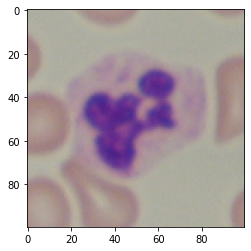

In [ ]:
plt.imshow(Xr_rgb[0, :, :, :]);

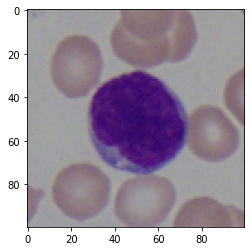

In [ ]:
plt.imshow(Xr_rgb[130, :, :, :]);

Nesta etapa, os índices de 0 a 259 são divididos em conjuntos de treinamento e teste, juntamente com o conjunto de alvos correspondentes.

In [ ]:
indtr, indte, ytr, yte = train_test_split(range(260), y, test_size=0.5)

## Rede com Valores Reais

Nesta seção, utilizaremos um modelo convencional de redes convolucionais para classificação de imagens. Iremos utilizar os canais de cores RGB para treinar a rede.

In [ ]:
Xtr = Xr_rgb[indtr]
Xte = Xr_rgb[indte]

In [ ]:
modelo_real = kr.Sequential(
    [
        kr.layers.Conv2D(8, kernel_size=(3, 3), activation="relu", input_shape=Xtr.shape[1:]),
        kr.layers.MaxPooling2D(pool_size=(2, 2)),
        kr.layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        kr.layers.MaxPooling2D(pool_size=(2, 2)),
        kr.layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        kr.layers.MaxPooling2D(pool_size=(2, 2)),
        kr.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        kr.layers.MaxPooling2D(pool_size=(2, 2)),
        kr.layers.Flatten(),
        kr.layers.Dropout(0.5),
        kr.layers.Dense(1, activation=None)
    ]
)

modelo_real.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 16)       0

Aqui, especificamos o número de épocas para treinar o modelo. Utilizamos também a classe keras.preprocessing.image.ImageDataGenerator que é capaz de aplicar uma série de transformações nas imagens, criando variações artificiais. Essas transformações incluem rotações, flutuações horizontais e verticais, zoom in e out, mudanças de brilho, entre outras. O objetivo é gerar uma variedade maior de exemplos para o modelo aprender, evitando o overfitting e melhorando a generalização.

Em seguida, compilamos o modelo utilizando o otimizador Adam e a função de perda Binary Cross Entropy.

Por fim, realizamos o ajuste do modelo utilizando o conjunto de treinamento.

In [ ]:
n_epocas = 150

# Aumento de conjunto de treino utilizando apenas giro vertical e horizontal
datagen = kr.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(Xtr)
it = datagen.flow(Xtr, ytr, batch_size=32)
batch = it.next()

tf.keras.backend.clear_session()

modelo_real.compile(optimizer='adam',
      loss=kr.losses.BinaryCrossentropy(from_logits=True),
      metrics=[kr.metrics.BinaryAccuracy()])

hist = modelo_real.fit(datagen.flow(Xtr, ytr, batch_size=32), epochs=n_epocas, verbose=1, validation_data=(Xte, yte))

Acc_tr = accuracy_score(ytr, modelo_real.predict(Xtr).flatten()>=0)
Acc_te = accuracy_score(yte, modelo_real.predict(Xte).flatten()>=0)

print("Real-valued Accuracy (Train/Test) = %2.2f/%2.2f" % (Acc_tr, Acc_te))

Epoch 1/150
5/5 [==============================] - 1s 105ms/step - loss: 0.6973 - binary_accuracy: 0.5077 - val_loss: 0.6907 - val_binary_accuracy: 0.4923
Epoch 2/150
5/5 [==============================] - 0s 37ms/step - loss: 0.6883 - binary_accuracy: 0.5077 - val_loss: 0.6874 - val_binary_accuracy: 0.4923
Epoch 3/150
5/5 [==============================] - 0s 35ms/step - loss: 0.6858 - binary_accuracy: 0.5077 - val_loss: 0.6859 - val_binary_accuracy: 0.4923
Epoch 4/150
5/5 [==============================] - 0s 40ms/step - loss: 0.6879 - binary_accuracy: 0.5077 - val_loss: 0.6837 - val_binary_accuracy: 0.4923
Epoch 5/150
5/5 [==============================] - 0s 36ms/step - loss: 0.6780 - binary_accuracy: 0.5077 - val_loss: 0.6769 - val_binary_accuracy: 0.4923
Epoch 6/150
5/5 [==============================] - 0s 38ms/step - loss: 0.6748 - binary_accuracy: 0.5077 - val_loss: 0.6701 - val_binary_accuracy: 0.4923
Epoch 7/150
5/5 [==============================] - 0s 33ms/step - loss: 0.6

Matriz de confusão dos resultados:

In [ ]:
confusion_matrix(yte, modelo_real.predict(Xte).flatten()>=0)

5/5 [==============================] - 0s 5ms/step


array([[63,  1],
       [ 2, 64]])

Precisão e sensibilidade do modelo:

In [ ]:
precision_score(yte, modelo_real.predict(Xte).flatten()>=0), recall_score(yte, modelo_real.predict(Xte).flatten()>=0)

5/5 [==============================] - 0s 3ms/step


(0.9846153846153847, 0.9696969696969697)

## Rede Hipercomplexa A[-1,+1]

Na seção anterior, foi utilizado um modelo convencional de redes convolucionais que utilizou os canais de cores RGB. Nesta seção, para fins de demonstração, será utilizado um modelo de rede hipercomplexa da álgebra $A[-1,+1]$, que é uma álgebra de Clifford de 4 dimensões.

Para este modelo hipercomplexo, escolhemos utilizar o conjunto de imagens no canal de cor HSV, pois alguns estudos sugeriram que é mais adequado para redes hipercomplexas em comparação com o RGB. No entanto, é importante notar que a escolha da álgebra $A[-1,+1]$ foi arbitrária e outras álgebras de Clifford de 4 dimensões também podem ser utilizadas com o modelo de rede hipercomplexa.

In [ ]:
Xtr = Xq_hsv[indtr]
Xte = Xq_hsv[indte]

tf.keras.backend.clear_session()

gama1, gama2 = -1, 1 # A[-1,+1]

algebra = np.array([[gama1, +1, gama1], [-1, gama2, -gama2], [-gama1, gama2, -gama1 * gama2]])

datagen = kr.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(Xtr)
it = datagen.flow(Xtr, ytr, batch_size=32)
batch = it.next()

modelo_hiper = kr.Sequential(
    [
        layers.Input(shape=Xtr.shape[1:]),
        HiperConv2D(4, kernel_size=(3, 3), activation="relu", algebra = algebra),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HiperConv2D(8, kernel_size=(3, 3), activation="relu", algebra = algebra),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HiperConv2D(8, kernel_size=(3, 3), activation="relu", algebra = algebra),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HiperConv2D(16, kernel_size=(3, 3), activation="relu", algebra = algebra),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation=None),
    ]
)

modelo_hiper.summary()


/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hiper_conv2d (HiperConv2D)  (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 hiper_conv2d_1 (HiperConv2D  (None, 47, 47, 32)       1184      
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 hiper_conv2d_2 (HiperConv2D  (None, 21, 21, 32)       2336      
 )                                                      

Observa-se que, na rede hipercomplexa, cada camada possui metade dos filtros em comparação com a camada correspondente na rede com valores reais. Isso ocorre devido ao fato de que cada camada hipercomplexa possui mais pesos associados a ela para o mesmo número de filtros. No entanto, o número total de parâmetros em ambas as redes é da mesma ordem de grandeza.

O modelo hipercomplexo foi compilado com as mesmas configurações do modelo convencional, utilizando o otimizador Adam e a função de custo Binary Cross Entropy.

In [ ]:
modelo_hiper.compile(optimizer='adam',
              loss=kr.losses.BinaryCrossentropy(from_logits=True),
              metrics=[kr.metrics.BinaryAccuracy()])

modelo_hiper.fit(datagen.flow(Xtr, ytr, batch_size=32),epochs=n_epocas, verbose=0, validation_data=(Xte,yte))


Apresentamos os resultados obtidos, incluindo a matriz de confusão e as métricas de precisão e recall.

In [ ]:
confusion_matrix(yte, modelo_hiper_a.predict(Xte).flatten()>=0)

5/5 [==============================] - 0s 6ms/step


array([[57,  7],
       [ 1, 65]])

In [ ]:
precision_score(yte, modelo_hiper_a.predict(Xte).flatten()>=0), recall_score(yte, modelo_hiper_a.predict(Xte).flatten()>=0)

5/5 [==============================] - 0s 6ms/step


(0.9027777777777778, 0.9848484848484849)

## Carregando dados dos Modelos

Foram treinados quatro modelos diferentes em 50 repetições cada um:

* Modelo com valores reais e canais RGB
* Modelo hipercomplexo da álgebra Cl(0,2) com canais HSV
* Modelo hipercomplexo da álgebra Cl(1,1) com canais HSV
* Modelo hipercomplexo da álgebra Cl(2,0) com canais HSV

Ao todo, foram gerados 200 modelos e avaliados seus respectivos desempenhos em termos de acurácia. Esses dados de acurácia podem ser carregados a partir de um dataframe utilizando a biblioteca Pandas.


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/IC - CNN/dados/acuracia_modelos.csv", index_col='Unnamed: 0')

In [ ]:
df

,Real-RGB,"Cl(0,2)-HSV","Cl(1,1)-HSV","Cl(2,0)-HSV"
0,0.984615,0.953846,0.938462,0.953846
1,0.938462,0.961538,0.676923,0.969231
2,0.961538,0.961538,0.969231,0.961538
3,0.853846,0.938462,0.953846,0.976923
4,0.946154,0.969231,0.969231,0.976923
5,0.761538,0.969231,0.976923,0.984615
6,0.976923,0.861538,0.969231,0.984615
7,0.876923,0.976923,0.976923,0.992308
8,0.807692,0.976923,0.961538,0.938462
9,0.892308,0.961538,0.969231,0.976923


Ao plotar um boxplot para cada um dos modelos, é possível realizar uma comparação entre os resultados obtidos por cada modelo.

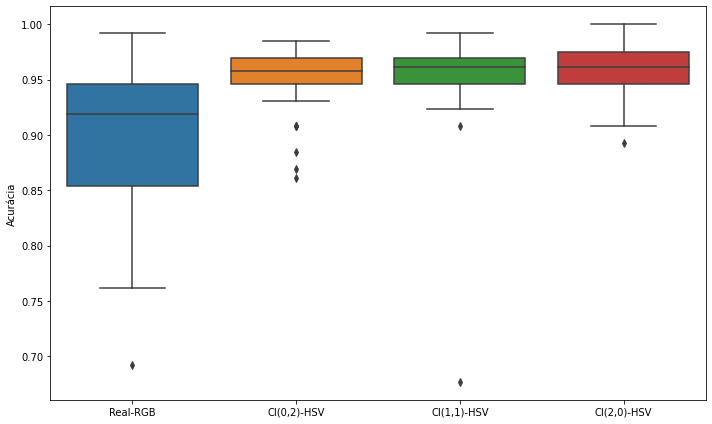

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

ax = sns.boxplot(data=df)
ax.set_ylabel('Acurácia')

fig.tight_layout()

In [ ]:
df.describe()

,Real-RGB,"Cl(0,2)-HSV","Cl(1,1)-HSV","Cl(2,0)-HSV"
count,50.000000,50.000000,50.000000,50.000000
mean,0.896462,0.951231,0.953538,0.958462
std,0.069086,0.027123,0.043927,0.022787
min,0.692308,0.861538,0.676923,0.892308
25%,0.853846,0.946154,0.946154,0.946154
50%,0.919231,0.957692,0.961538,0.961538
75%,0.946154,0.969231,0.969231,0.975000
max,0.992308,0.984615,0.992308,1.000000


Ao analisar os boxplots, podemos observar que os modelos hipercomplexos apresentaram, em média, desempenhos superiores aos modelos com valores reais. Dentre as álgebras utilizadas para os modelos hipercomplexos, a rede com álgebra Cl(2,0) obteve a melhor média de acurácia, além de apresentar uma das melhores medianas, um valor máximo mais alto e um desvio padrão menor em comparação aos demais modelos.

# Conclusão

Redes neurais convolucionais com valores hipercomplexos mostraram-se uma abordagem promissora para a análise de imagens, especialmente em aplicações médicas. Os resultados obtidos neste trabalho demonstraram que esses modelos têm um desempenho superior em relação às redes convencionais, especialmente quando utilizados em conjunto com álgebra de Clifford de dimensão 4.

Este estudo pode ser ampliado para a área de visão computacional de detecção de objetos, onde o objetivo seria identificar linfoblastos em uma imagem com diversos glóbulos brancos. Essa aplicação pode ser muito útil, pois muitas vezes os médicos precisam contar manualmente o número de linfoblastos em uma imagem. Se integrados a um software, esses modelos poderiam executar essa tarefa automaticamente, permitindo que os médicos se concentrem em outras tarefas mais importantes e menos mecânicas. Em resumo, esta pesquisa abre um caminho para a utilização de modelos com valores hipercomplexos em outras aplicações de análise de imagens, especialmente na área médica.